In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from gym import spaces
from gym.utils import seeding
from collections import namedtuple
from tqdm import tqdm
import warnings
warnings.filterwarnings(action="ignore")

### Data

In [27]:
df = pd.read_excel("Data/HS300.xlsx")
look_back = 5
horizon = 5

indicators = [f'look_back_{i}_open' for i in range(look_back)] + [f'look_back_{i}_close' for i in range(look_back)] +\
             [f'look_back_{i}_high' for i in range(look_back)] + [f'look_back_{i}_low' for i in range(look_back)] +\
             [f'look_back_{i}_vol' for i in range(look_back)]

def Z_score(df):
    for i in range(look_back):
        df[f'look_back_{i}_open'] = (df['open'].shift(i) - df['open'].expanding(252).mean()) / df['close'].expanding(252).std()
        df[f'look_back_{i}_close'] = (df['close'].shift(i) - df['close'].expanding(252).mean()) / df['close'].expanding(252).std()
        df[f'look_back_{i}_high'] = (df['high'].shift(i) - df['high'].expanding(252).mean()) / df['high'].expanding(252).std()
        df[f'look_back_{i}_low'] = (df['low'].shift(i) - df['low'].expanding(252).mean()) / df['low'].expanding(252).std()
        df[f'look_back_{i}_vol'] = (df['volume'].shift(i) - df['volume'].expanding(252).mean()) / df['volume'].expanding(252).std()
    df['close_horizon'] = df['close'].shift(-1 * horizon)
    df.dropna(inplace=True)
    return df

import math
def train_test_split(train_size, df):
    size = math.ceil(train_size * len(df))
    train_df = df.iloc[:size, :]
    test_df = df.iloc[size:, :]
    return train_df ,test_df

data = Z_score(df)
train_df, test_df = train_test_split(.7, data)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Traing Dataset info: ", train_df.shape)
print("Test Dataset info: ", test_df.shape)

Traing Dataset info:  (3396, 32)
Test Dataset info:  (1455, 32)


### Run Code

In [4]:
random_list = []
i = 0
while i < 11:
    random_list.append(random.randint(0, 1000))
    i += 1
random_list

[914, 741, 225, 859, 848, 707, 409, 133, 975, 919, 811]

In [28]:
# from tqdm import tqdm
from Agent import DQN
from Environment import StockTradingEnv

episodes = 30

def Train_DQN(env: StockTradingEnv):
    agent = DQN(**agent_param)
    print('\nCollecting experience...')
    for i_episode in tqdm(range(episodes), desc="Training episode: "):
    # for i_episode in range(episodes):
        state = env.reset()  # 获得初始化 observation 环境特征
        ep_r = 0 # 作为一个计数变量，来统计我第n次训练。 完成所有动作的分的总和
        while True:
            action = agent.choose_action(state)
            state, reward, done, next_state = env.step(action)
            # 存储数据  每完成一个动作，记忆存储数据一次
            agent.memorize(state, reward, action, next_state)
            ep_r += reward
            # 数据库中多于memory size时候就会学习
            agent.learn()
            if done:
                # 打印这是i_episode次训练, Ep_reward代表这次的总分
                # print('Ep: ', i_episode+1, '| Ep_reward: ', round(ep_r, 2))
                break
            state = next_state
    return agent


def Test_DQN(env_config, test_data: pd.DataFrame, agent):
    """
    :param env_config: dict
    :param test_data: trade data about test time
    :param agent: agent object
    """
    print("start predicting...")
    env = StockTradingEnv(test_data, **env_config)
    state = env.reset()
    ep_r = 0
    while True:
        action = agent.choose_action(state)
        state, reward, done, next_state = env.step(action)
        ep_r += reward
        if done:
            break
        state = next_state
    print(f'reward: {ep_r}')
    result = env.plot_df
    return result

# random_list = []
# i = 0
# while i < 6:
#     random_list.append(random.randint(0, 1000))
#     i += 1
# print(random_list)
random_list = [294, 185, 7, 300, 368, 724]

result = {}
for seed in random_list:
    torch.manual_seed(seed)
    np.random.seed(seed)
    agent_param = {
        "n_states": 25,
        "n_actions": 3,
        "capacity": 64,
        "epsilon_start": .9,
        "epsilon_end": .05,
        "epsilon_decay": 500,
        "batch_size": 32,
        "gamma": .9,
        "replace_iter": 5
    }
    env_params = {
        "buy_cost_pct": 0.0005,
        "sell_cost_pct": 0.0005,
        "tech_indicator_list": indicators,
        "seed": seed
    }
    # reinforecement learning
    train_env = StockTradingEnv(df = train_df, **env_params)
    agent = Train_DQN(train_env)
    res_df = Test_DQN(test_data=test_df, env_config=env_params, agent=agent)
    # save result
    result[f"seed_{seed}"] = res_df

Training episode: 100%|██████████| 30/30 [07:02<00:00, 14.10s/it]


start predicting...
reward: -0.7856707362361147



Training episode: 100%|██████████| 30/30 [06:51<00:00, 13.70s/it]


start predicting...
reward: -0.129914058747704



Training episode: 100%|██████████| 30/30 [06:46<00:00, 13.53s/it]


start predicting...
reward: 0.9465167137332723



Training episode: 100%|██████████| 30/30 [06:50<00:00, 13.70s/it]


start predicting...
reward: 0.686688596237864



Training episode: 100%|██████████| 30/30 [07:00<00:00, 14.01s/it]


start predicting...
reward: 1.2063448312286766



Training episode: 100%|██████████| 30/30 [07:03<00:00, 14.13s/it]


start predicting...
reward: 0.018559151249672


In [29]:
df = res_df[['date', 'close']]
signal_col = []
for seed in random_list:
    signal_col.append(f"seed_{seed}")
    df[f"seed_{seed}"] = result[f"seed_{seed}"]['signal']
df['signal'] = df[signal_col].mode(axis=1)[0]
df = df[['date', 'close', 'signal']]
# df

In [30]:
import copy
from Functions import Get_PosRet, Sharp_Ratio
# df = copy.deepcopy(result)
df = Get_PosRet(df)
df['benchmark'] = df['close'].pct_change()
df['cum_mkt'] = (1 + df['benchmark']).cumprod() - 1
df['cum_ret'] = (1 + df['return']).cumprod() - 1
df.set_index("date", inplace=True)
df.to_excel("gamma_0.9.xlsx")
df

,close,signal,is_position,investment,return,benchmark,cum_mkt,cum_ret
date,,,,,,,,
2018-12-21,3029.395,0.0,0,0.000,0.000000,NaN,NaN,0.000000
2018-12-24,3038.198,0.0,0,0.000,0.000000,0.002906,0.002906,0.000000
2018-12-25,3017.282,0.0,0,0.000,0.000000,-0.006884,-0.003998,0.000000
2018-12-26,3002.033,2.0,1,3002.033,0.000000,-0.005054,-0.009032,0.000000
2018-12-27,2990.506,0.0,0,2990.506,-0.003840,-0.003840,-0.012837,-0.003840
...,...,...,...,...,...,...,...,...
2024-12-13,3933.181,1.0,0,3988.831,0.000000,-0.023662,0.298339,0.316378
2024-12-16,3911.842,0.0,0,3988.831,0.000000,-0.005425,0.291295,0.316378
2024-12-17,3922.033,2.0,1,3922.033,0.000000,0.002605,0.294659,0.316378


In [31]:
# from Functions import MDD, InfoRatio
def MDD(df: pd.DataFrame):
    md = ((df.cummax() - df) / df.cummax()).max()
    return md

def InfoRatio(df, benchmark):
    ex_return = df - benchmark
    information = np.sqrt(len(ex_return)) * ex_return.mean() / ex_return.std()
    return information


ann_ret = (1 + df['return'].mean()) ** 252 - 1
ann_vol = df['return'].std() * (252 ** .5)
sharp_ratio = Sharp_Ratio(df['return'])
mdd = MDD(df['investment'])
calmar = df['return'].mean() / mdd
cumret = df['cum_ret'].iloc[-1]
inforatio = InfoRatio(df['return'], df['benchmark'])

index = ['年化收益率','年化波动率','夏普比率','最大回撤','Calmar比率','累计收益率','信息比率']
value = [ann_ret, ann_vol, sharp_ratio, mdd, calmar, cumret, inforatio]
pd.DataFrame({"horizion:10":value}, index=index).T

,年化收益率,年化波动率,夏普比率,最大回撤,Calmar比率,累计收益率,信息比率
horizion:10,0.055712,0.105699,0.527086,0.430675,0.0005,0.324242,-0.132397


In [7]:
def annualize(df):  
    return ((1+ df) ** (252/len(df)) - 1) * 100
df[['banchmark', 'cumret']] = annualize(df[['banchmark', 'cumret']])

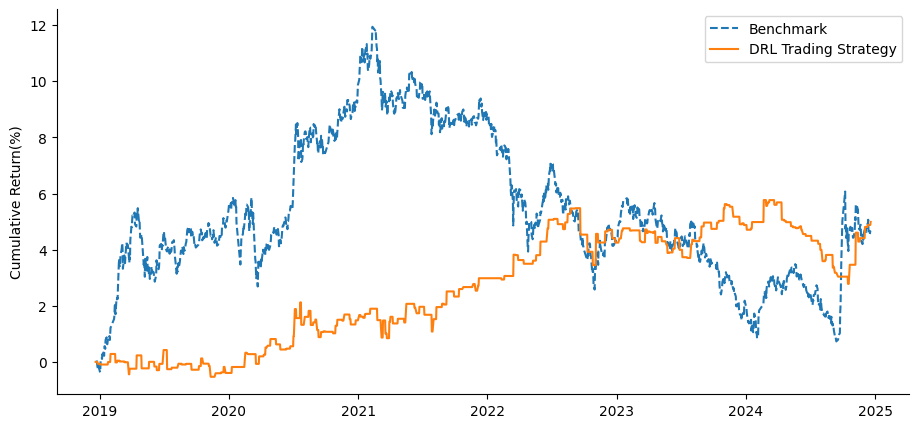

In [8]:
# 创建图表
fig, ax = plt.subplots(figsize=(11, 5))
# 去除上方和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(df['banchmark'], label='Benchmark', linestyle='--')
plt.plot(df['cumret'], label="DRL Trading Strategy")
plt.legend()
plt.ylabel("Cumulative Return(%)")
plt.show()

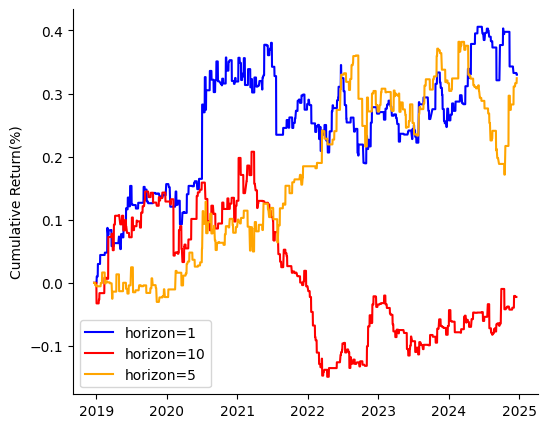

In [35]:
plt_df = pd.read_excel("结果.xlsx", index_col=0, sheet_name="horizon")
# 创建图表
fig, ax = plt.subplots(figsize=(6, 5))
# 去除上方和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
color_lis = ['blue', 'red', 'orange']
for col, color in zip(plt_df.columns, color_lis):
    plt.plot(plt_df[col], label=col, color=color)
plt.legend()
plt.ylabel("Cumulative Return(%)")
plt.show()